# Waterflow

Pour ce projet nous devons développer un outil pour l'identification d'eau potable à la consommation humaine. Ce notebook est décomposé en plusieurs parties:  
- 1. Prétraitement des données et EDA  
- 2. Création d'un MLP from scratch et entraînement + prédiction  
- 3. Création d'un MLP avec Keras et entraînement + prédiction  
- 4. Utilisation d'XGboost et entraînement + prédiction  

#### Imports

In [17]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb


## 1. Prétraitement des données et EDA

Tout d'abord nous récupérons les données et nous en visualisons la distribution ainsi que les valeurs nulles par variables.

In [4]:
df = pd.read_csv("../data/water_potability.csv")

print(df.describe())

print("\nValeurs manquantes par colonne :")
df.isna().sum()


                ph     Hardness        Solids  Chloramines      Sulfate  \
count  2785.000000  3276.000000   3276.000000  3276.000000  2495.000000   
mean      7.080795   196.369496  22014.092526     7.122277   333.775777   
std       1.594320    32.879761   8768.570828     1.583085    41.416840   
min       0.000000    47.432000    320.942611     0.352000   129.000000   
25%       6.093092   176.850538  15666.690297     6.127421   307.699498   
50%       7.036752   196.967627  20927.833607     7.130299   333.073546   
75%       8.062066   216.667456  27332.762127     8.114887   359.950170   
max      14.000000   323.124000  61227.196008    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   3276.000000     3276.000000      3114.000000  3276.000000  3276.000000  
mean     426.205111       14.284970        66.396293     3.966786     0.390110  
std       80.824064        3.308162        16.175008     0.780382     0.487849  


ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Nous supprimons les valeurs manquantes. 

In [26]:
df_clean = df.dropna()

df_clean.to_csv('../data/df_clean.csv', index=False)

Nous réalisons une visualisation du jeu de données

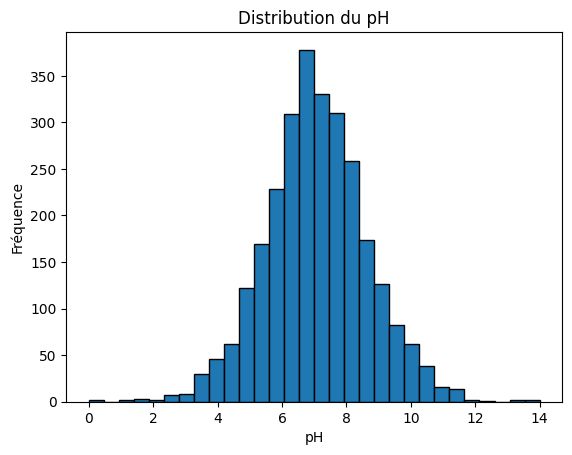

In [6]:
plt.hist(df['ph'].dropna(), bins=30, edgecolor='k')
plt.title('Distribution du pH')
plt.xlabel('pH')
plt.ylabel('Fréquence')
plt.show()

Et nous vérifions la répartition des échantillons d'eau (0 = Non potable / 1 = Potable)

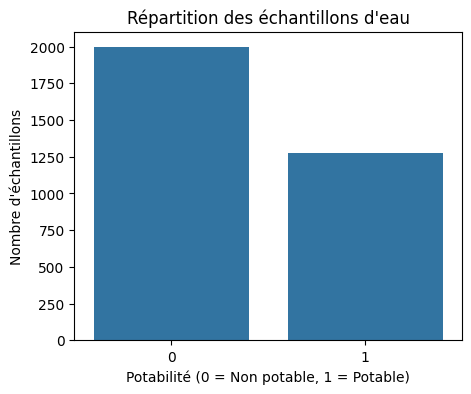

In [7]:
plt.figure(figsize=(5,4))
sns.countplot(x="Potability", data=df)
plt.title("Répartition des échantillons d'eau")
plt.xlabel("Potabilité (0 = Non potable, 1 = Potable)")
plt.ylabel("Nombre d'échantillons")
plt.show()

La distribution du pH est centrée autour de 7, ce qui correspond globalement à une eau neutre, adaptée à la consommation. Les valeurs extrêmes observées (près de 0 et 14) devront être vérifiées, car elles pourraient fausser l’identification de l’eau potable.


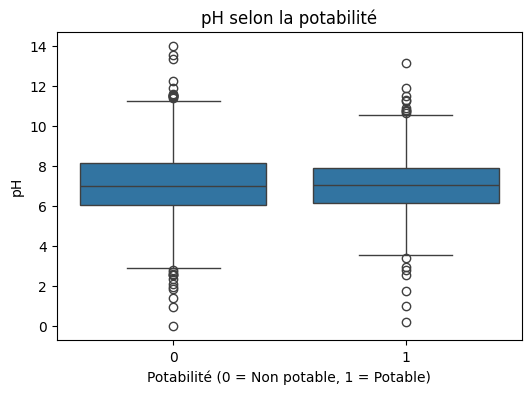

In [8]:
plt.figure(figsize=(6,4))
sns.boxplot(x="Potability", y="ph", data=df)
plt.title("pH selon la potabilité")
plt.xlabel("Potabilité (0 = Non potable, 1 = Potable)")
plt.ylabel("pH")
plt.show()

Le graphe montre que le pH n’est pas un critère suffisant pour distinguer l’eau potable de l’eau non potable. Les deux distributions se recouvrent largement, ce qui signifie qu’un pH “normal” n’exclut pas la présence d’autres contaminants.


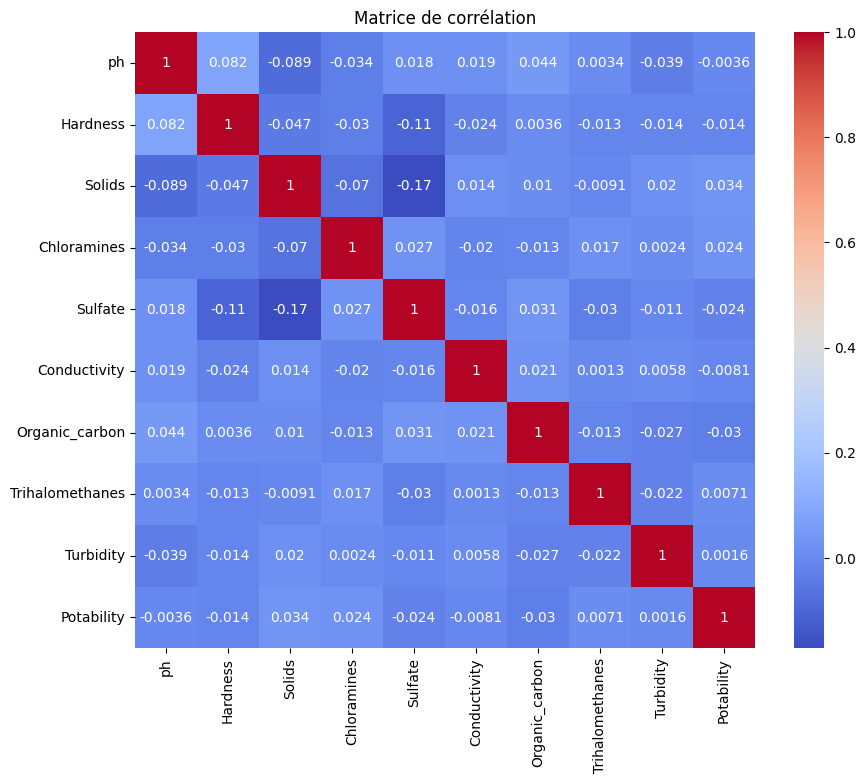

In [9]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()


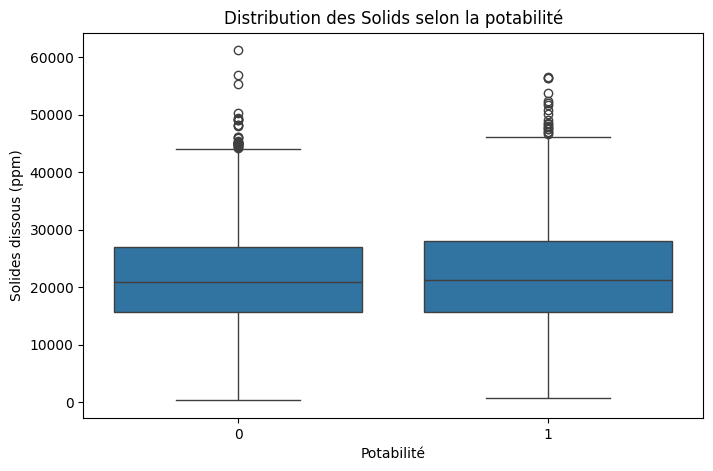

In [10]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Potability', y='Solids', data=df)
plt.title('Distribution des Solids selon la potabilité')
plt.xlabel('Potabilité')
plt.ylabel('Solides dissous (ppm)')
plt.show()

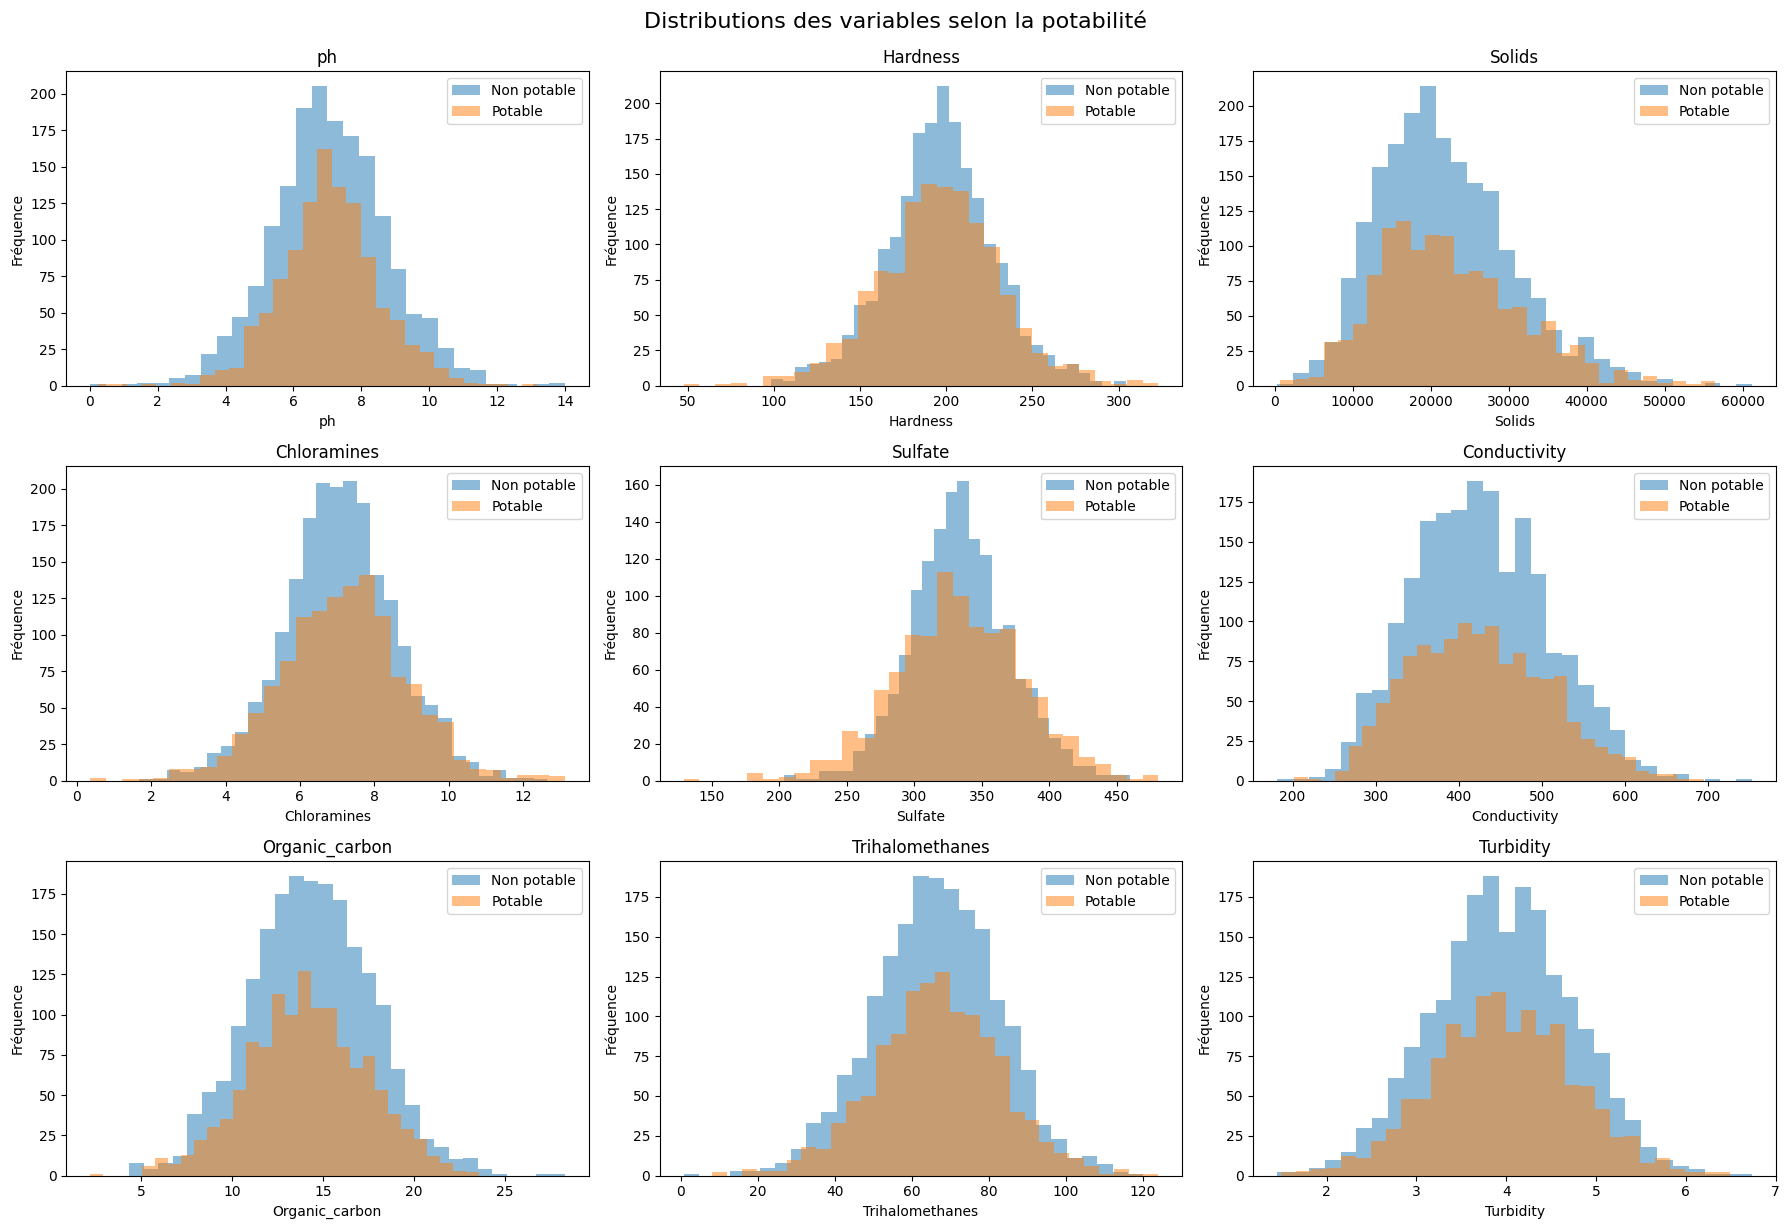

In [11]:
num_vars = [
    "ph", "Hardness", "Solids", "Chloramines", "Sulfate",
    "Conductivity", "Organic_carbon", "Trihalomethanes", "Turbidity"
]

# On crée une grille de 3 lignes x 3 colonnes
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()  # Pour itérer plus facilement

for i, var in enumerate(num_vars):
    axes[i].hist(
        df[df["Potability"]==0][var].dropna(),
        bins=30, alpha=0.5, label="Non potable"
    )
    axes[i].hist(
        df[df["Potability"]==1][var].dropna(),
        bins=30, alpha=0.5, label="Potable"
    )
    axes[i].set_title(f'{var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("Fréquence")
    axes[i].legend()

# Ajuste les espacements
plt.tight_layout()
plt.suptitle('Distributions des variables selon la potabilité', fontsize=16, y=1.02)
plt.show()

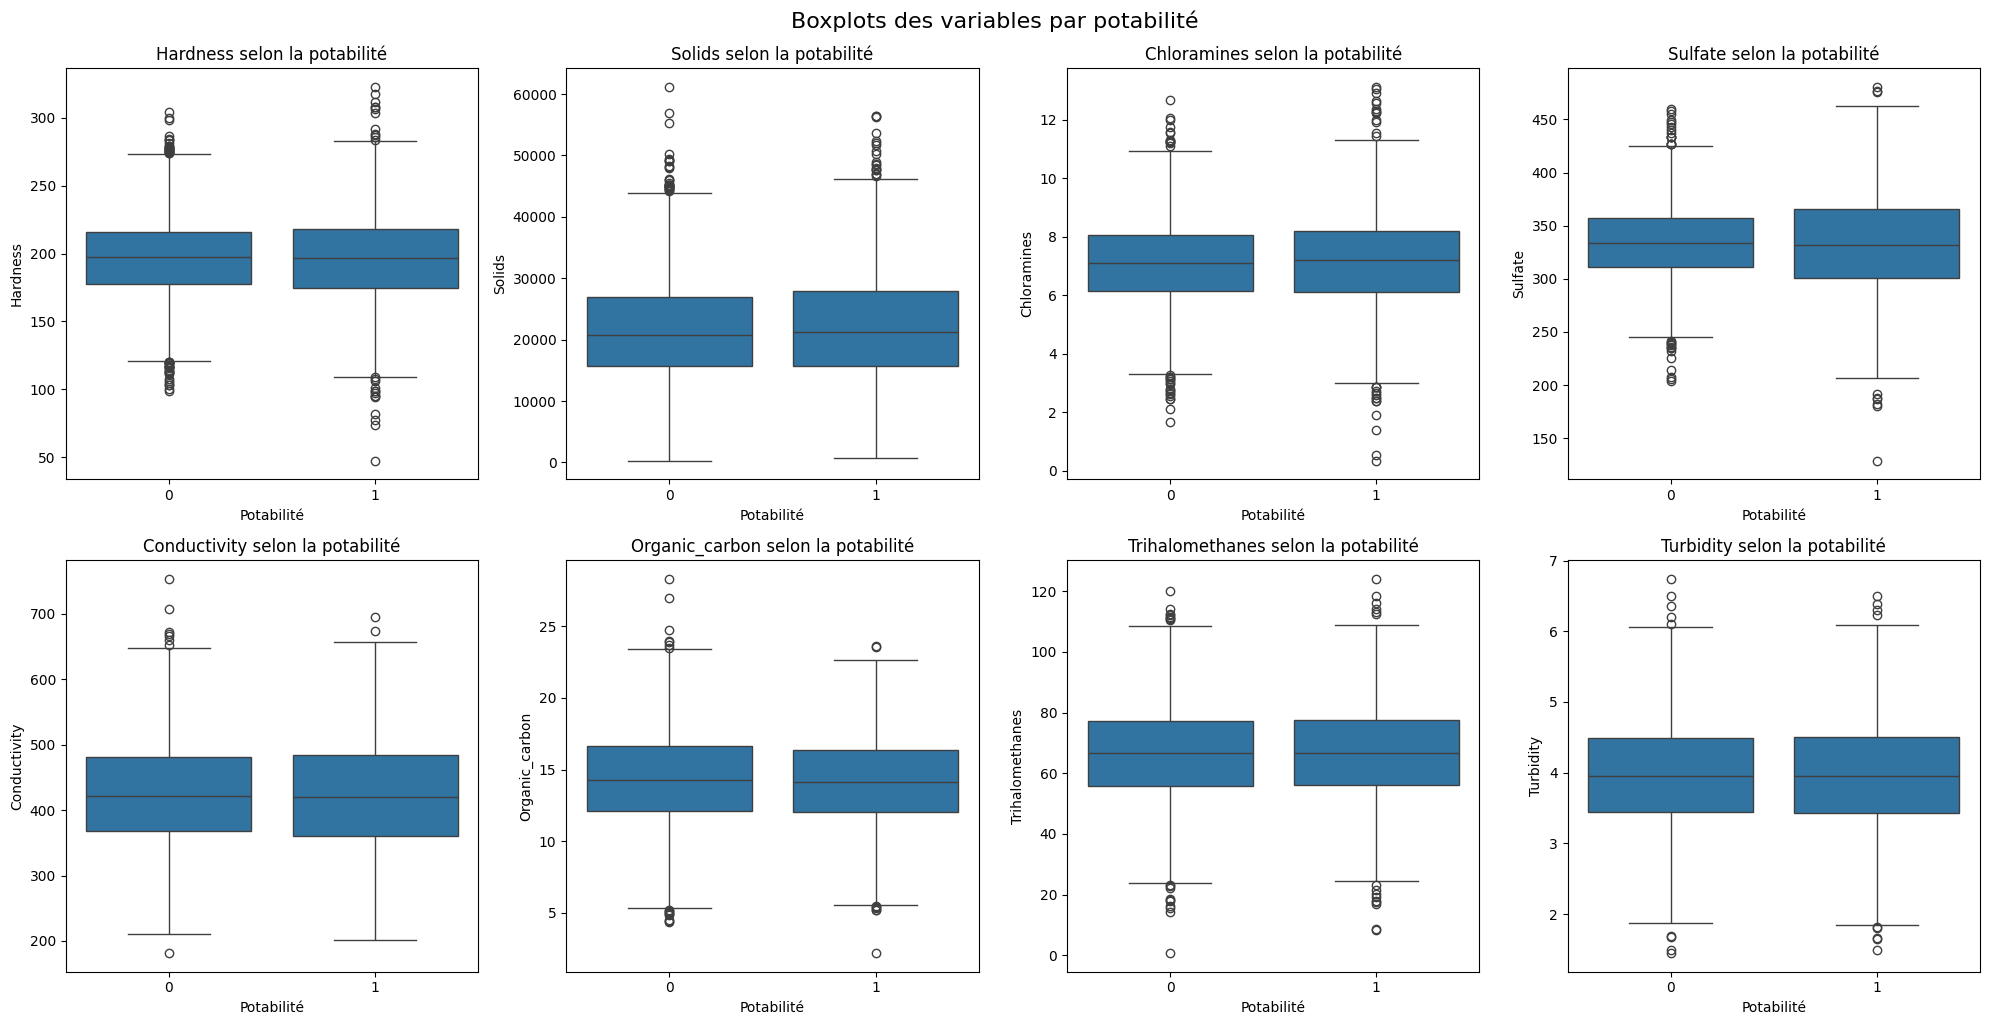

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(20,10))
axes = axes.flatten()

num_vars_no_ph = [
    "Hardness", "Solids", "Chloramines", "Sulfate",
    "Conductivity", "Organic_carbon", "Trihalomethanes", "Turbidity"
]

for i, var in enumerate(num_vars_no_ph):
    sns.boxplot(x="Potability", y=var, data=df, ax=axes[i])
    axes[i].set_title(f"{var} selon la potabilité")
    axes[i].set_xlabel("Potabilité")
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.suptitle("Boxplots des variables par potabilité", fontsize=16, y=1.02)
plt.show()


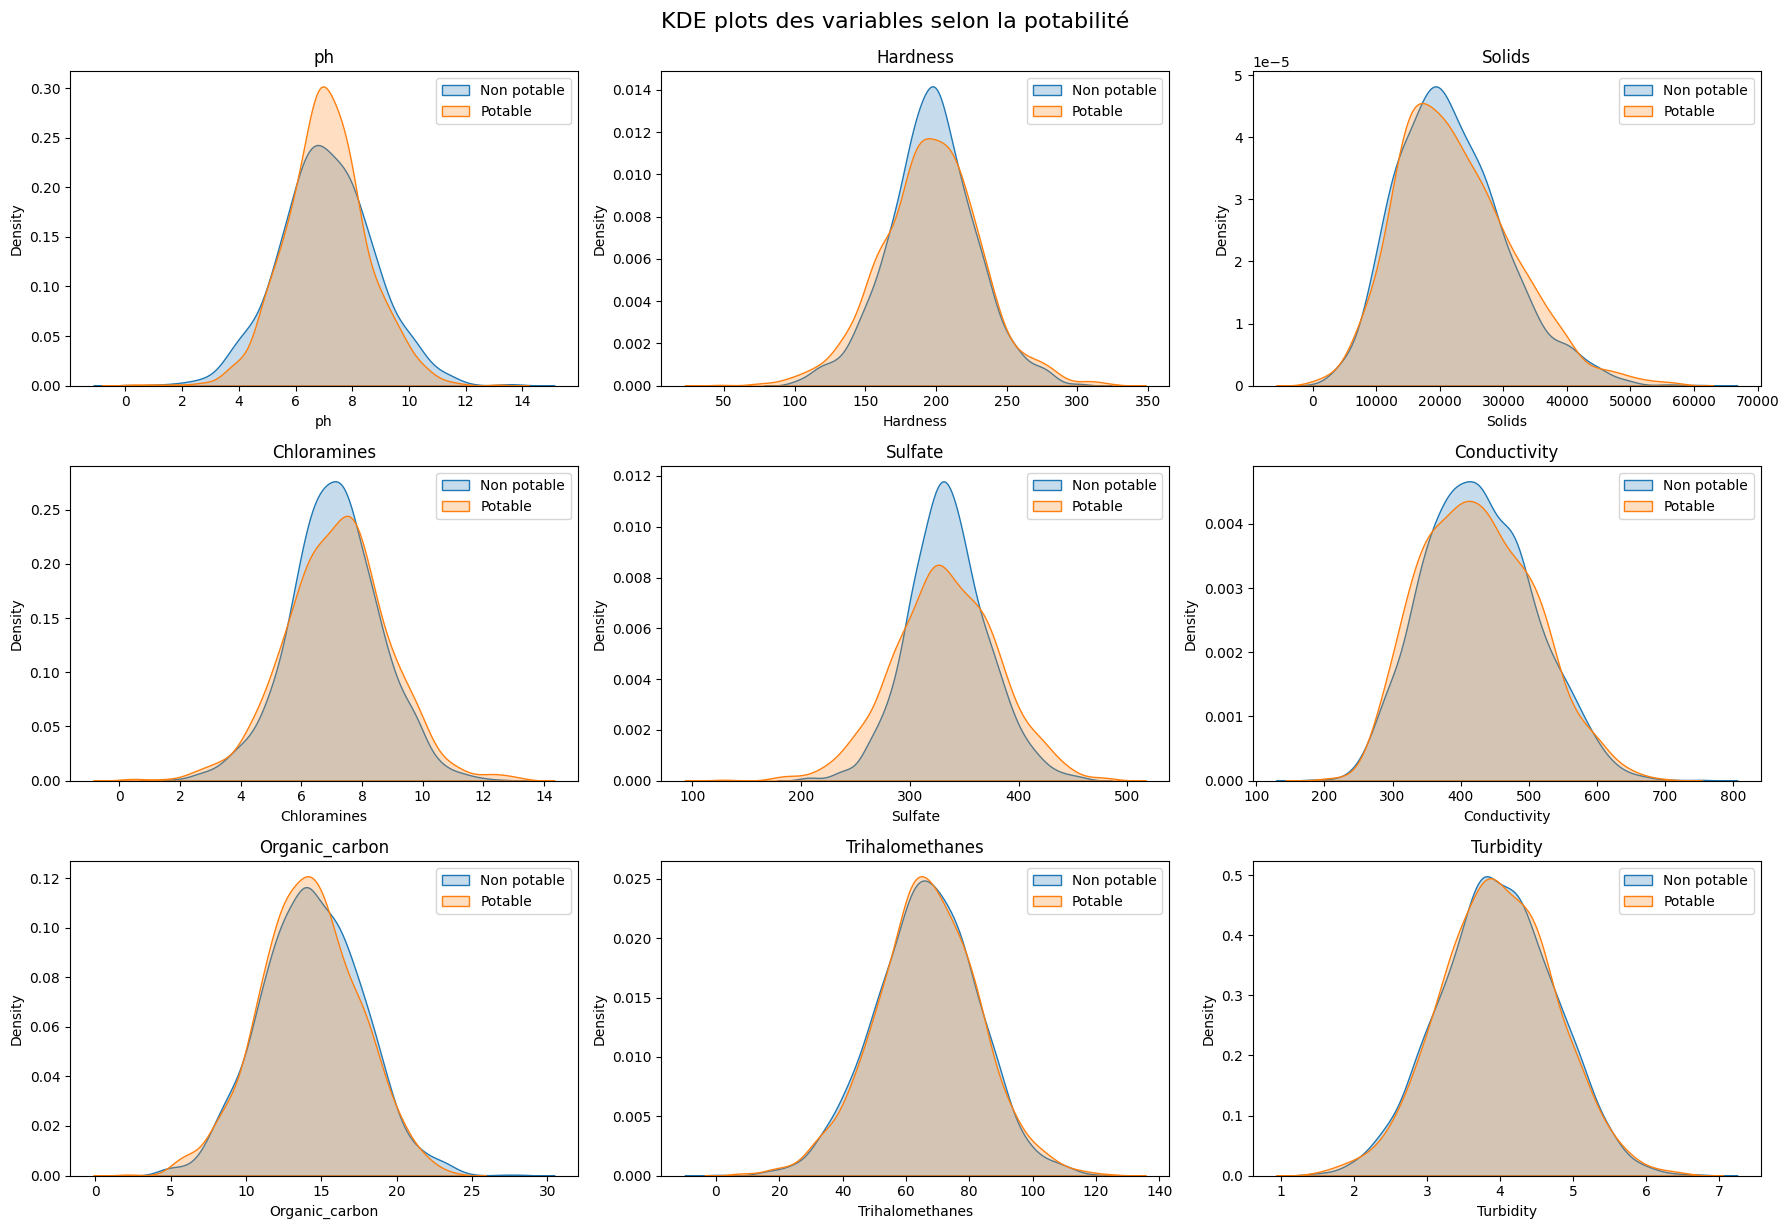

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(18,12))
axes = axes.flatten()

for i, var in enumerate(num_vars):
    sns.kdeplot(
        df[df["Potability"]==0][var].dropna(),
        label="Non potable",
        fill=True,
        ax=axes[i]
    )
    sns.kdeplot(
        df[df["Potability"]==1][var].dropna(),
        label="Potable",
        fill=True,
        ax=axes[i]
    )
    axes[i].set_title(f"{var}")
    axes[i].legend()

plt.tight_layout()
plt.suptitle("KDE plots des variables selon la potabilité", fontsize=16, y=1.02)
plt.show()

## 2. Création d'un MLP from scratch et entraînement + prédiction 

In [14]:
# Extraire les données
X = df_clean.drop("Potability", axis=1).values
y = df_clean["Potability"].values.reshape(-1,1)

# Normaliser
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X_norm = (X - X_min) / (X_max - X_min)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y, test_size=0.2, random_state=42)

print("Taille X_train :", X_train.shape)
print("Taille X_test :", X_test.shape)

# Fonctions d'activation
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

# Dimensions
input_size = X_train.shape[1]
hidden1_size = 50
hidden2_size = 30
output_size = 1
N_train = X_train.shape[0]

# Initialisation des poids et biais
np.random.seed(0)
W1 = np.random.randn(input_size, hidden1_size) * np.sqrt(2 / input_size)
b1 = np.zeros((1, hidden1_size))

W2 = np.random.randn(hidden1_size, hidden2_size) * np.sqrt(2 / hidden1_size)
b2 = np.zeros((1, hidden2_size))

W3 = np.random.randn(hidden2_size, output_size) * 0.01
b3 = np.zeros((1, output_size))

# 7. Paramètres d'apprentissage
learning_rate = 0.1
epochs = 10000

# 8. Entraînement
for epoch in range(epochs):
    # Forward pass
    Z1 = np.dot(X_train, W1) + b1
    A1 = relu(Z1)

    Z2 = np.dot(A1, W2) + b2
    A2 = relu(Z2)

    Z3 = np.dot(A2, W3) + b3
    A3 = sigmoid(Z3)

    # Calcul de la perte (Binary Cross-Entropy)
    epsilon = 1e-8
    loss = -np.mean(y_train * np.log(A3 + epsilon) + (1 - y_train) * np.log(1 - A3 + epsilon))

    # Backpropagation
    dZ3 = A3 - y_train
    dW3 = np.dot(A2.T, dZ3) / N_train
    db3 = np.sum(dZ3, axis=0, keepdims=True) / N_train

    dA2 = np.dot(dZ3, W3.T)
    dZ2 = dA2 * relu_derivative(Z2)
    dW2 = np.dot(A1.T, dZ2) / N_train
    db2 = np.sum(dZ2, axis=0, keepdims=True) / N_train

    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = np.dot(X_train.T, dZ1) / N_train
    db1 = np.sum(dZ1, axis=0, keepdims=True) / N_train

    # Mise à jour des poids et biais
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1

    # Afficher la perte tous les 500 epochs
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Erreur (Binary Cross-Entropy) : {loss}")

Z1_test = np.dot(X_test, W1) + b1
A1_test = relu(Z1_test)

Z2_test = np.dot(A1_test, W2) + b2
A2_test = relu(Z2_test)

Z3_test = np.dot(A2_test, W3) + b3
A3_test = sigmoid(Z3_test)

predictions_test = (A3_test > 0.5).astype(int)

# Accuracy
accuracy_test = np.mean(predictions_test == y_test)
print("Accuracy sur le jeu de test :", accuracy_test)

#  Afficher exemple de prédictions
print("Exemple de prédictions test :", predictions_test[:20].flatten())

# Distribution des classes dans le test
print("Répartition des classes (test) :", np.bincount(y_test.flatten().astype(int)))

print(classification_report(y_test, predictions_test))



Taille X_train : (1608, 9)
Taille X_test : (403, 9)
Epoch 0, Erreur (Binary Cross-Entropy) : 0.6921169718621085
Epoch 500, Erreur (Binary Cross-Entropy) : 0.6705948452300647
Epoch 1000, Erreur (Binary Cross-Entropy) : 0.6668563488306818
Epoch 1500, Erreur (Binary Cross-Entropy) : 0.6569482172197262
Epoch 2000, Erreur (Binary Cross-Entropy) : 0.635942990283743
Epoch 2500, Erreur (Binary Cross-Entropy) : 0.6025982985048268
Epoch 3000, Erreur (Binary Cross-Entropy) : 0.5833423846718274
Epoch 3500, Erreur (Binary Cross-Entropy) : 0.5678747133134469
Epoch 4000, Erreur (Binary Cross-Entropy) : 0.5546536502421964
Epoch 4500, Erreur (Binary Cross-Entropy) : 0.5504601095606413
Epoch 5000, Erreur (Binary Cross-Entropy) : 0.5469905413679356
Epoch 5500, Erreur (Binary Cross-Entropy) : 0.5457396765735857
Epoch 6000, Erreur (Binary Cross-Entropy) : 0.5432927792291888
Epoch 6500, Erreur (Binary Cross-Entropy) : 0.5359081681960747
Epoch 7000, Erreur (Binary Cross-Entropy) : 0.5333135824900705
Epoch 75

### Interprétation des résultats du MLP from scratch

Le perceptron multicouche (MLP) entraîné manuellement a montré une amélioration progressive de l'erreur de classification (binary cross-entropy) au fil des itérations, passant de 0.69 à environ 0.51 après 9500 epochs. Cette décroissance lente mais constante de la perte montre que le modèle apprend progressivement des motifs dans les données, bien qu’il ait fallu beaucoup d’epochs pour atteindre ce niveau de performance, ce qui peut refléter une optimisation lente ou une architecture simple.  

Sur l’ensemble de test (20 % des données), le MLP atteint une accuracy de 65.76 %, ce qui reste modeste, mais montre une capacité du modèle à généraliser partiellement. Le rapport de classification indique :  

- Classe 0 (eau non potable) : précision de 70 % et rappel de 71 % → meilleure reconnaissance.  

- Classe 1 (eau potable) : précision de 60 % et rappel de 59 % → plus difficile à identifier correctement.  

Cela peut s'expliquer par une légère déséquilibre de classes dans le dataset (231 vs 172) et peut indiquer que le modèle a tendance à mieux prédire la classe majoritaire (0).  

Enfin, le f1-score moyen (macro et weighted) autour de 0.65 montre une performance raisonnable mais améliorable. Le MLP from scratch est donc un bon point de départ, mais pourrait bénéficier d’optimisations (architecture, régularisation, ou ajustements de learning rate).  

## 3. Création d'un MLP Keras et entraînement + prédiction

c:\wamp64\www\waterflow\env\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,545 (49.00 KB)

 Trainable params: 12,097 (47.25 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5049 - loss: 0.8601 - val_accuracy: 0.5528 - val_loss: 0.6910
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5293 - loss: 0.7757 - val_accuracy: 0.5528 - val_loss: 0.7038
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5755 - loss: 0.7426 - val_accuracy: 0.5528 - val_loss: 0.7214
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5858 - loss: 0.6980 - val_accuracy: 0.5528 - val_loss: 0.7300
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5754 - loss: 0.7232 - val_accuracy: 0.5528 - val_loss: 0.7289
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5724 - loss: 0.7102 - val_accuracy: 0.5528 - val_loss: 0.7304
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5945 - loss: 0.6636 - val_accuracy: 0.5528 - val_loss: 0.7295
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6097 - loss: 0.6845 - val_accuracy: 0.5528 - 

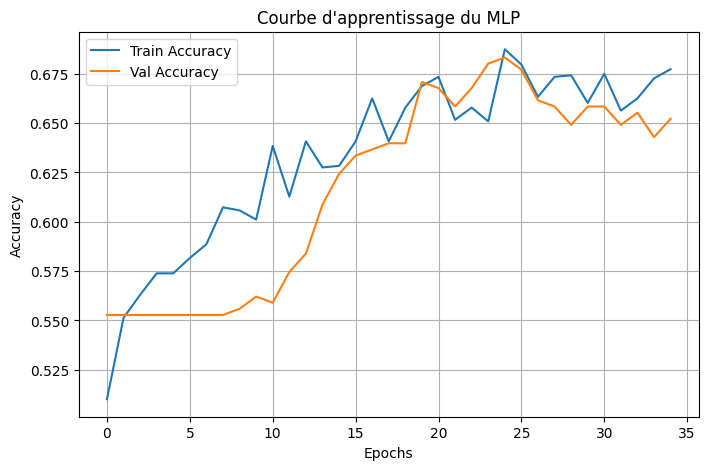

In [ ]:
X = df_clean.drop("Potability", axis=1).values
y = df_clean["Potability"].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)


model = Sequential()

model.add(Dense(128, activation='relu', input_shape=(X.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu')) 
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\n Test Accuracy: {test_acc * 100:.2f}%")


plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Courbe d'apprentissage du MLP")
plt.legend()
plt.grid(True)
plt.show()


### Interprétation des résultats du MLP Keras

Le modèle MLP entraîné avec Keras présente une architecture plus robuste que celui codé from scratch, notamment grâce à l’intégration de plusieurs couches cachées, de Dropout, de BatchNormalization et de l’optimiseur Adam.  

**Entraînement & EarlyStopping**  
Le modèle a été entraîné sur un ensemble de données avec une validation interne (20 % du X_train) et un early stopping qui a stoppé l’apprentissage à l’époque 30 pour éviter le surapprentissage, en restaurant les meilleurs poids.  

**Performance**
L’accuracy finale sur le jeu de test est de 68,49 %, ce qui est légèrement supérieur à celui du MLP from scratch (~65.76 %).  

L’évolution des courbes d’apprentissage montre une amélioration régulière de la précision sur l’ensemble de validation jusqu’à environ l’époque 20, ce qui confirme la bonne efficacité du early stopping.  

La val_accuracy s’est stabilisée autour de 66 %, indiquant que le modèle a atteint un plateau de performance sans signe de surapprentissage brutal.  

**Conclusion**
Ce MLP bénéficie de l'efficacité de Keras et d’une meilleure architecture :  

- Il est plus stable,  

- plus rapide à entraîner (grâce à la vectorisation et l’optimisation automatique),  

- Et il atteint une performance légèrement meilleure, malgré un nombre d’epochs très inférieur (30 vs 9500 dans le modèle from scratch).  

Cela valide que l'utilisation de bibliothèques haut niveau comme Keras permet non seulement de gagner en efficacité, mais aussi d’améliorer les résultats avec moins de complexité.

## 4. Utilisation d'XGboost et entraînement + prédiction

c:\wamp64\www\waterflow\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:30:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Accuracy XGBoost : 65.76%

 Rapport de classification :
              precision    recall  f1-score   support

           0       0.67      0.82      0.74       240
           1       0.61      0.42      0.50       163

    accuracy                           0.66       403
   macro avg       0.64      0.62      0.62       403
weighted avg       0.65      0.66      0.64       403



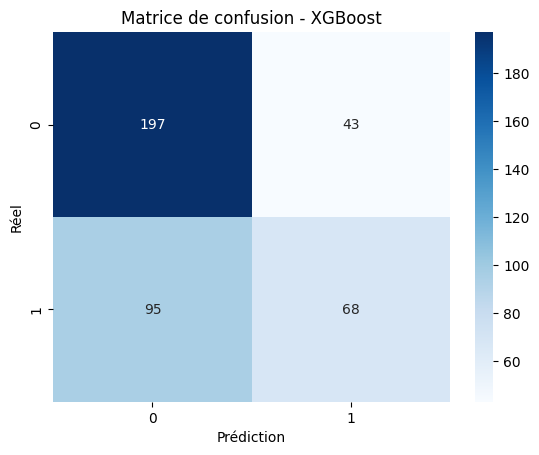

In [23]:
X = df_clean.drop("Potability", axis=1).values
y = df_clean["Potability"].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)


model_xgb = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

model_xgb.fit(X_train, y_train)


y_pred = model_xgb.predict(X_test)

acc_xgb = accuracy_score(y_test, y_pred)
print(f"\n Accuracy XGBoost : {acc_xgb * 100:.2f}%")

print("\n Rapport de classification :")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.title("Matrice de confusion - XGBoost")
plt.show()

### Interprétation des résultats du XGboost

Le modèle XGBoost, reconnu pour ses performances en classification binaire, a été entraîné sur les données de qualité de l’eau pour prédire la potabilité.  

**Résultats globaux**  
Accuracy sur le jeu de test : 65.76 %  

Cette performance est équivalente à celle obtenue avec le MLP Keras (~66 %), montrant que XGBoost reste très compétitif, même sans réseau de neurones.  

**Détails du rapport de classification**

| Classe              | Précision | Rappel | F1-score | Support |
| ------------------- | --------- | ------ | -------- | ------- |
| 0 (eau non potable) | 0.67      | 0.82   | 0.74     | 240     |
| 1 (eau potable)     | 0.61      | 0.42   | 0.50     | 163     |


Le modèle prédit très bien la classe majoritaire (0), avec un bon compromis entre rappel et précision.  

En revanche, il sous-performe sur la classe minoritaire (1), avec un rappel de 0.42, ce qui signifie que plus de la moitié des eaux potables ne sont pas reconnues comme telles.  

**Matrice de confusion**  
68 vrais positifs (potables bien prédits)  

95 faux négatifs : des eaux potables prédites comme non potables.  

Cela indique un biais vers la classe 0, typique des problèmes de classes déséquilibrées.  

**Conclusion**  
XGBoost montre une bonne robustesse générale, en particulier sur les données bien représentées. Toutefois, sa capacité à détecter les eaux potables reste limitée, suggérant qu’un rééquilibrage des classes (oversampling/SMOTE) ou un ajustement des poids pourrait améliorer les résultats.

### Comparaison des performances des trois modèles

| Modèle                        | Accuracy (%) | Précision classe 1 | Rappel classe 1 | F1-score classe 1 | Avantages                                                                                                            | Limites                                                                        |
| ----------------------------- | ------------ | ------------------ | --------------- | ----------------- | -------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------ |
| **MLP From Scratch**          | **65.76**    | 0.60               | 0.59            | 0.60              | Bon exercice de compréhension du fonctionnement interne d’un réseau de neurones. Résultats honnêtes sans frameworks. | Pas optimisé, pas de régularisation, pas de validation croisée.                |
| **MLP Keras (Deep Learning)** | **68.49**    | 0.63               | 0.57            | 0.60              | Architecture profonde, régularisation (Dropout, BatchNorm), early stopping, validation intégrée.                     | Légère tendance à overfitter, courbe bruitée.                                  |
| **XGBoost**                   | **65.76**    | 0.61               | 0.42            | 0.50              | Performant sur les classes majoritaires, facile à tuner, rapide à entraîner.                                         | Faible rappel sur la classe minoritaire, sensible au déséquilibre des classes. |
